<a href="https://colab.research.google.com/github/Mr-Wonderfool/TJ_MCM/blob/master/dynamic_stock_all.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import numpy as np
import pandas as pd
import datetime as dt
from matplotlib import pyplot as plt
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.metrics import mean_squared_error, mean_absolute_error
# from tensorflow.keras.models import Sequential, Model
# from tensorflow.keras.layers import Dense, LSTM, Dropout, Input, Conv1D, Flatten, concatenate
# from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
# !pip install keras-tcn
# from tcn import TCN
from google.colab import drive
import os
from tensorflow.keras.models import load_model
drive.mount('/content/drive')

def dynamic_stock(totalFund_, extraFund_, y_predict, y_true):
    totalFund = totalFund_
    extraFund = extraFund_ # split original fund for dynamic processing
    price_at_window_start, price_at_window_end = totalFund, 0
    stockNum = 0 # current number of stock at hand
    dayNum = len(y_predict)
    has_stock = False # has stock in hand currently
    for today in range(0, dayNum - 1): # take one day in advance
        if y_predict[today + 1] > y_true[today] and not has_stock:
            # stock predicted to be rising and dont have stock yet
            price_at_window_start = totalFund
            stockNum = totalFund / y_true[today]
            totalFund = 0
            has_stock = True
        elif y_predict[today + 1] < y_true[today] and has_stock:
            # price predicted to be falling, sell the stock
            totalFund = stockNum * y_true[today]
            has_stock = False
            # examine the stock
            price_at_window_end = totalFund
            ratio = price_at_window_start / price_at_window_end
            if ratio < 1:
                # promising stock, add more fund
                increment = totalFund * (1 - ratio)
                if extraFund < increment:
                    extraFund = 0
                    totalFund += extraFund
                else:
                    extraFund -= increment
                    totalFund += increment
            else:
                # reduce the fund in this stock
                decrement = totalFund * (ratio - 1)
                totalFund -= decrement
                extraFund += decrement
            print(f"Sold stock at day{today}, \n \
            totalFund: {totalFund}, extraFund: {extraFund}")

if __name__ == '__main__':
    predict_true = pd.read_csv('/content/drive/MyDrive/predictions/AA_predictions.csv')
    y_predict = np.array(predict_true['Predictions'])
    true_price = np.array(predict_true['Actual'])
    totalFund = 50
    extraFund = 50 # split original fund for dynamic processing
    dynamic_stock(totalFund, extraFund, y_predict, true_price)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Sold stock at day8, 
             totalFund: 49.46977192992394, extraFund: 50.26511403503803
Sold stock at day13, 
             totalFund: 49.24917290257966, extraFund: 50.37541354871017
Sold stock at day17, 
             totalFund: 51.825284641303426, extraFund: 49.08735767934829
Sold stock at day25, 
             totalFund: 51.12549891960382, extraFund: 49.437250540198086
Sold stock at day29, 
             totalFund: 52.12714039217581, extraFund: 48.93642980391209
Sold stock at day38, 
             totalFund: 46.071059487922234, extraFund: 51.96447025603888
Sold stock at day40, 
             totalFund: 46.933404720639736, extraFund: 51.53329763968013
Sold stock at day45, 
             totalFund: 49.726792106503034, extraFund: 50.13660394674848
Sold stock at day48, 
             totalFund: 53.815190282031075, extraFund: 48.09240485898446
Sold stock at day53,

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive

drive.mount('/content/drive')

extraFund = 400000  # Extra funds shared among all stocks

def dynamic_stock(totalFund, y_predict, y_true, global_extra_fund):
    initial_total_fund = totalFund  # Store initial fund for return calculation
    stockNum = 0  # Number of stocks
    has_stock = False  # Currently holding stock

    for today in range(len(y_predict) - 1):
        if y_predict[today + 1] > y_true[today] and not has_stock:
            # Predicted to rise and not currently holding stock
            stockNum = totalFund / y_true[today]
            totalFund = 0
            has_stock = True
        elif y_predict[today + 1] < y_true[today] and has_stock:
            # Predicted to fall and currently holding stock
            totalFund = stockNum * y_true[today]
            has_stock = False
            # Adjust funds based on performance
            if totalFund > initial_total_fund:
                # If profit, add more funds
                increment = (totalFund - initial_total_fund)
                if global_extra_fund[0] >= increment:
                    global_extra_fund[0] -= increment
                    totalFund += increment
            else:
                # If loss, reduce the fund
                decrement = (initial_total_fund - totalFund)
                if totalFund > decrement:
                    totalFund -= decrement
                    global_extra_fund[0] += decrement

    # Sell any remaining stock at the last price
    if has_stock:
        totalFund = stockNum * y_true[-1]

    return totalFund

def calculate_total_returns(weights):
    companies = ['A', 'AA', 'ABC', 'ABCB', 'ACLS', 'ACNB', 'ADBE', 'ADP', 'AEG', 'AIR']
    total_fund = 600000  # Initial investment
    total_initial_fund = total_fund + extraFund
    total_final_fund = 0

    total_weight = sum(weights.values())
    allocated_funds = {comp: (weight / total_weight) * total_fund for comp, weight in weights.items()}
    global_extra_fund = [extraFund]  # Use a list to maintain state across function calls

    for company in companies:
        file_path = f'/content/drive/MyDrive/predictions/{company}_predictions.csv'
        df = pd.read_csv(file_path)
        y_predict = df['Predictions'].values
        y_true = df['Actual'].values

        # Use allocated fund based on Monte Carlo weights
        allocated_fund = allocated_funds[company]
        final_fund = dynamic_stock(allocated_fund, y_predict, y_true, global_extra_fund)
        total_final_fund += final_fund

    total_return_rate = (total_final_fund - total_initial_fund + global_extra_fund[0]) / total_initial_fund * 100
    print(f"Total Return Rate: {total_return_rate:.2f}%, Remaining Extra Fund: {global_extra_fund[0]}")

if __name__ == '__main__':
    weights = {
        'A': 3.687049859524796, 'AA': 2.219831145816969, 'ABC': 3.1676117011522384, 'ABCB': 4.337304887824643,
        'ACLS': 3.4969123897615013, 'ACNB': 23.896297604274523, 'ADBE': 47.189297012758736, 'ADP': 6.802566702378293,
        'AEG': 1.6770488395957608, 'AIR': 3.5260798569125256
    }
    calculate_total_returns(weights)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Total Return Rate: 6.33%, Remaining Extra Fund: 3159.8800402730267


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


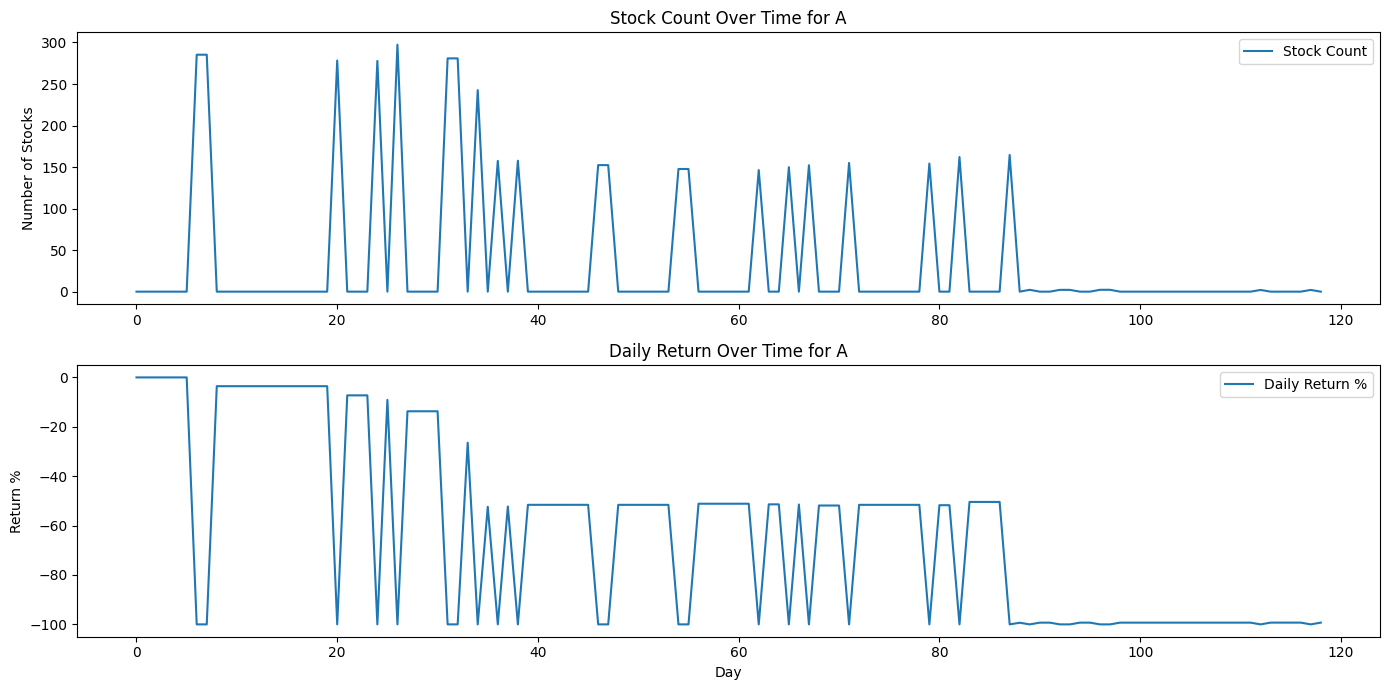

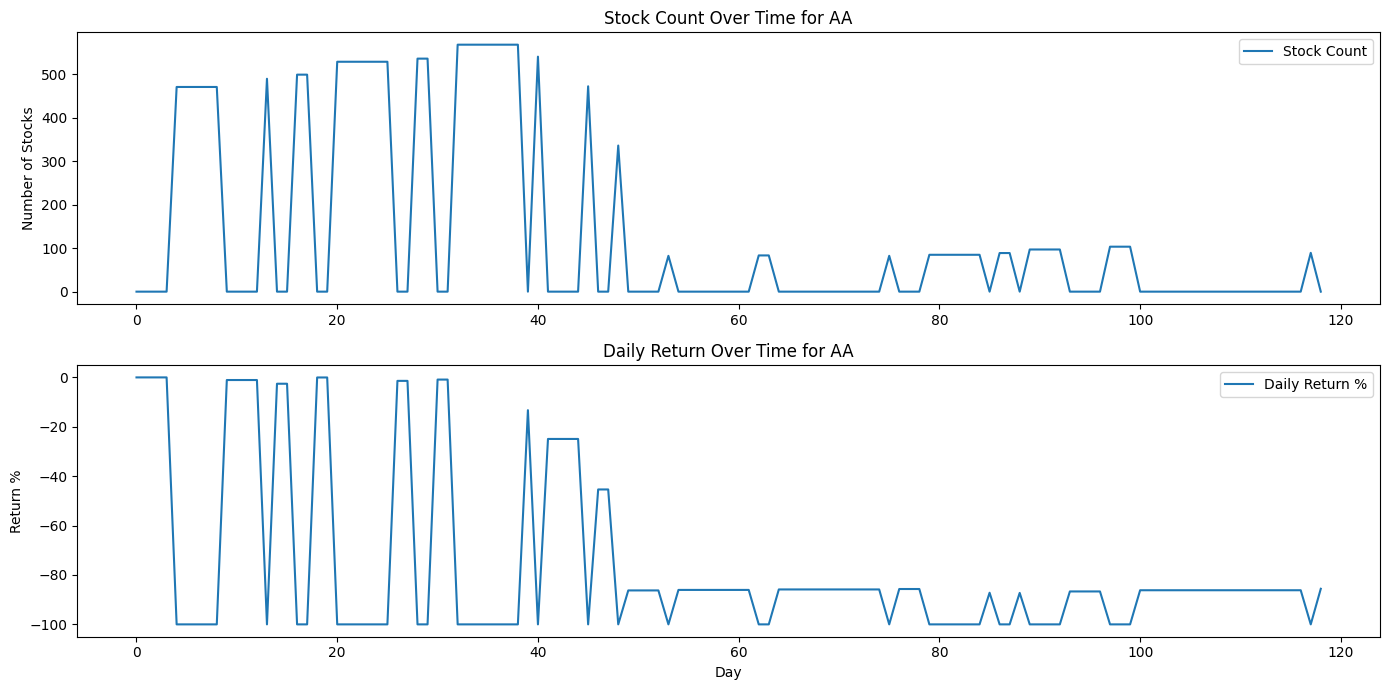

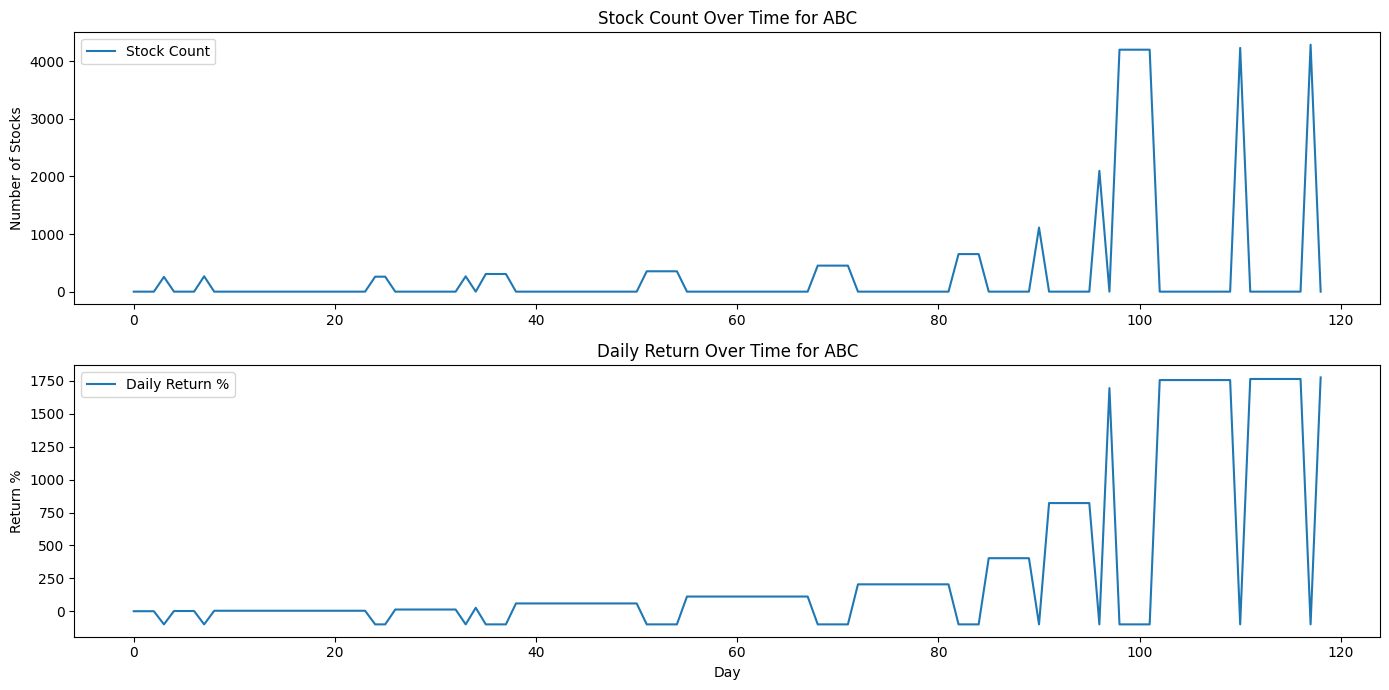

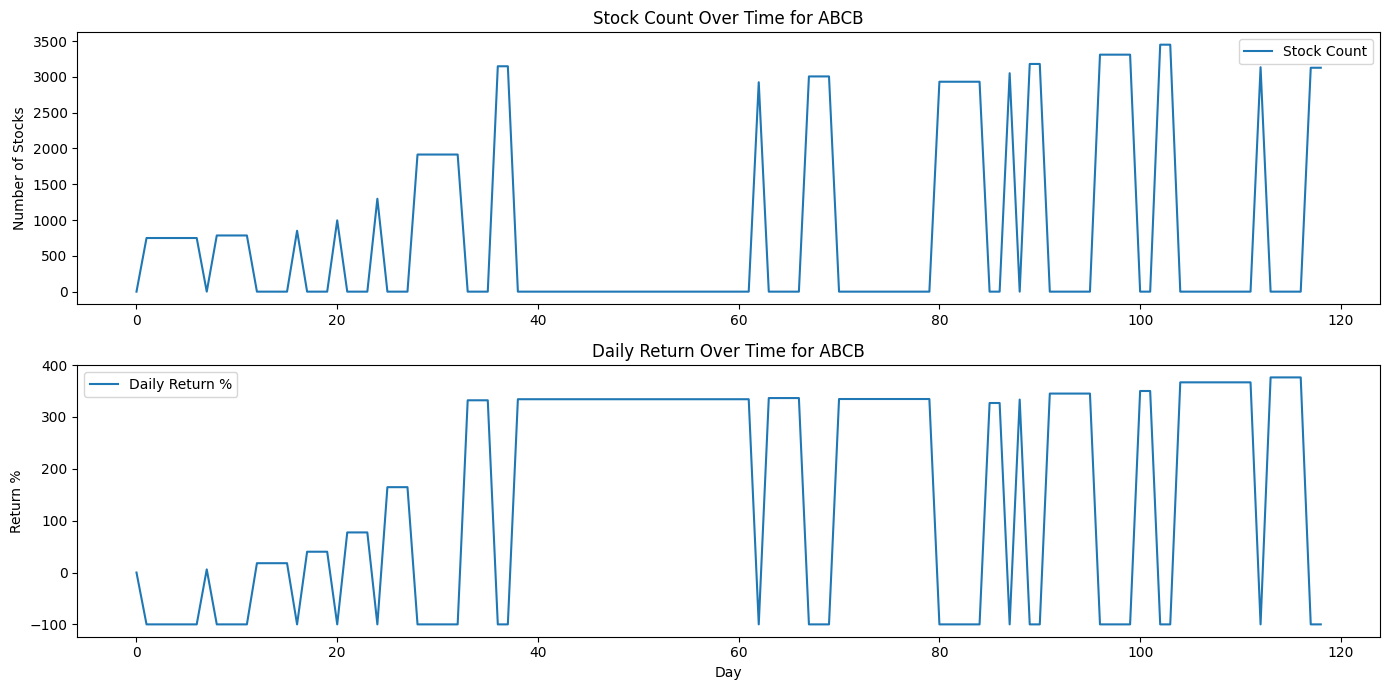

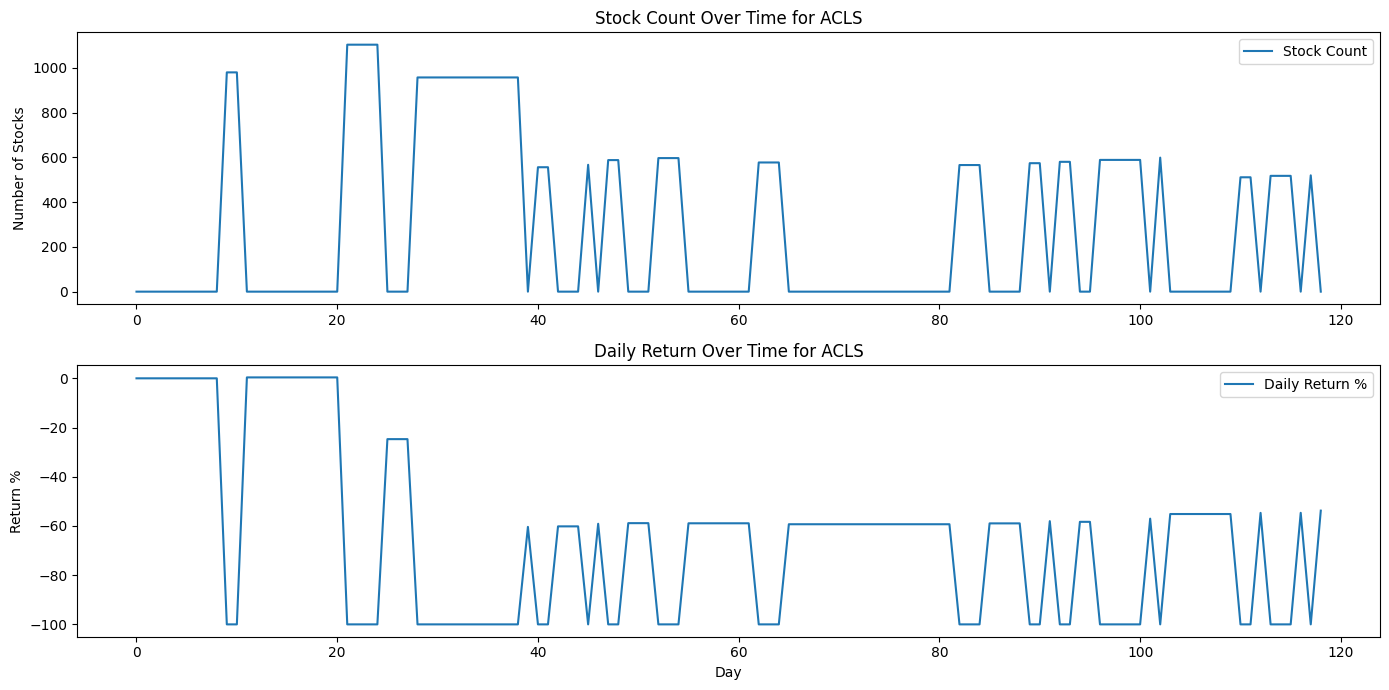

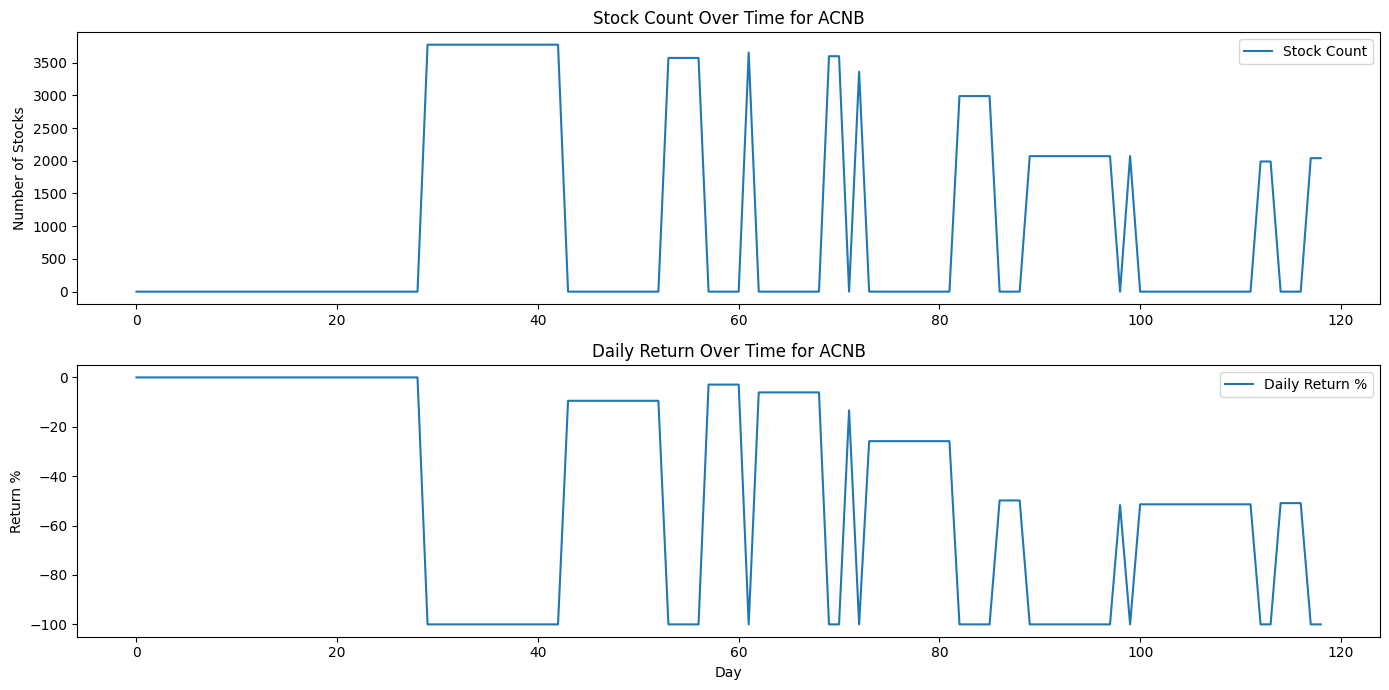

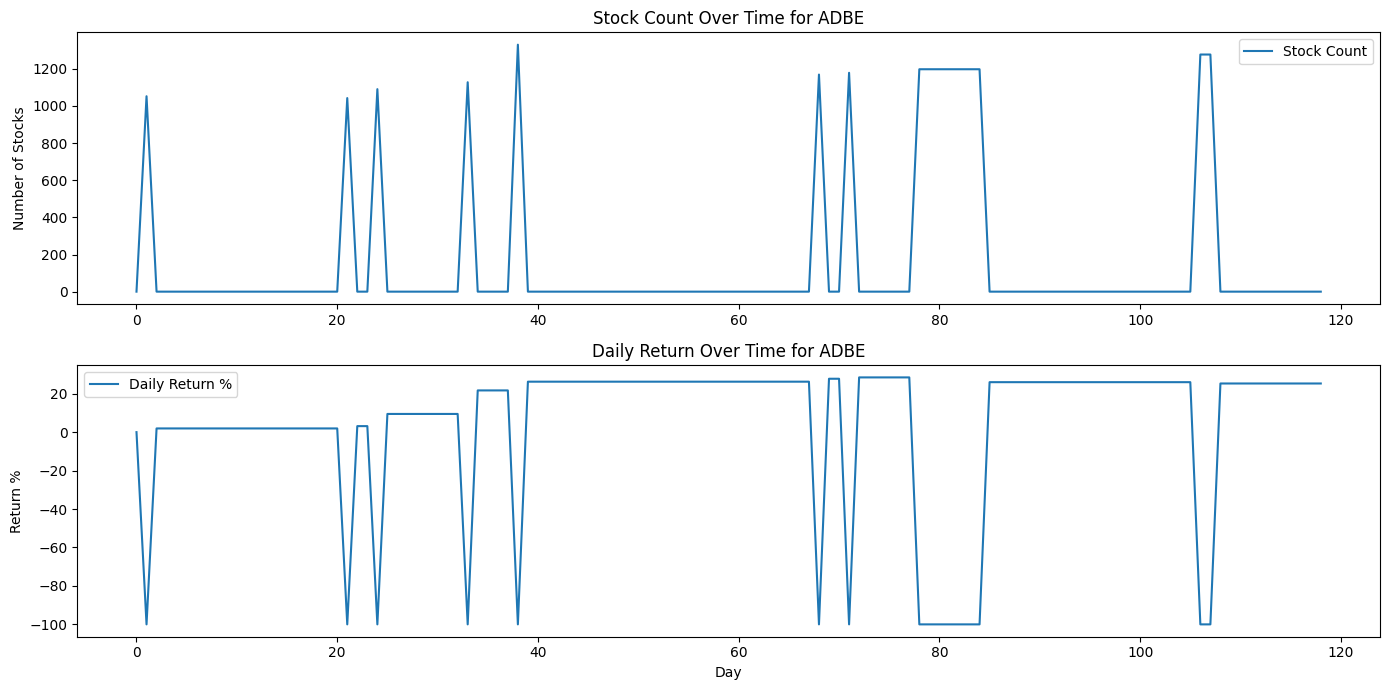

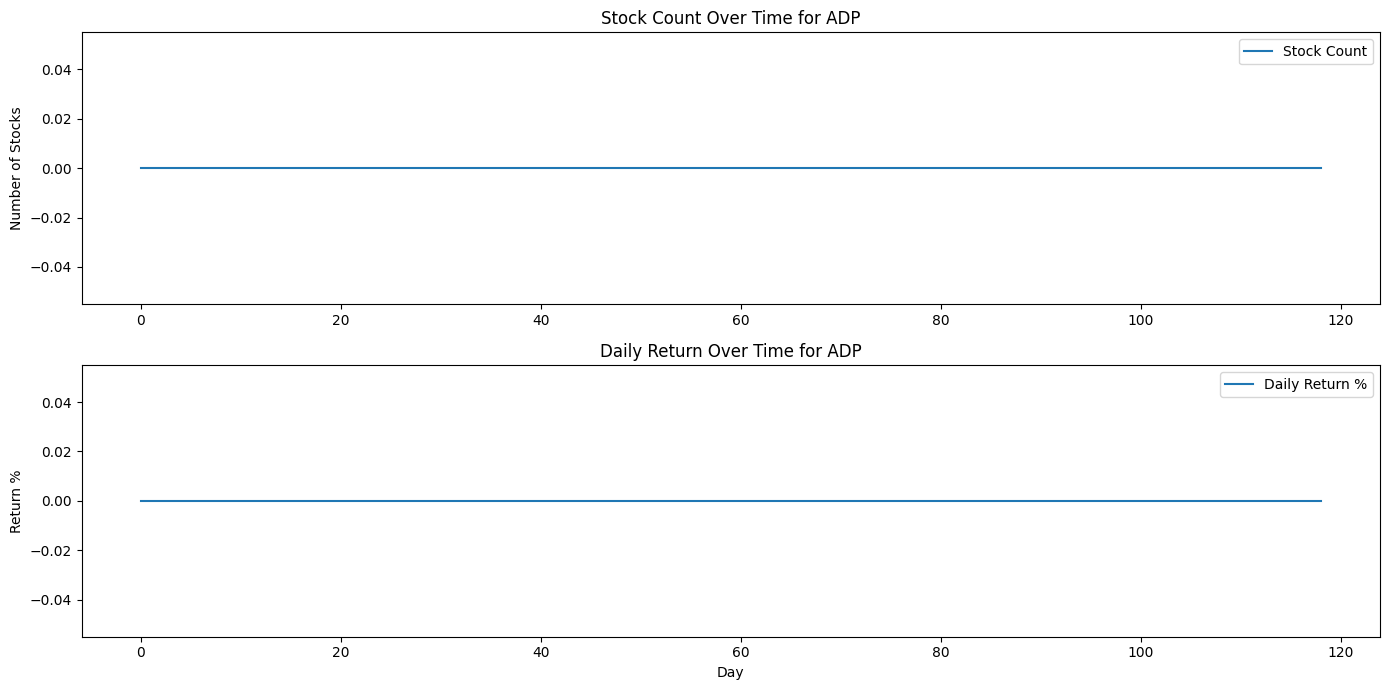

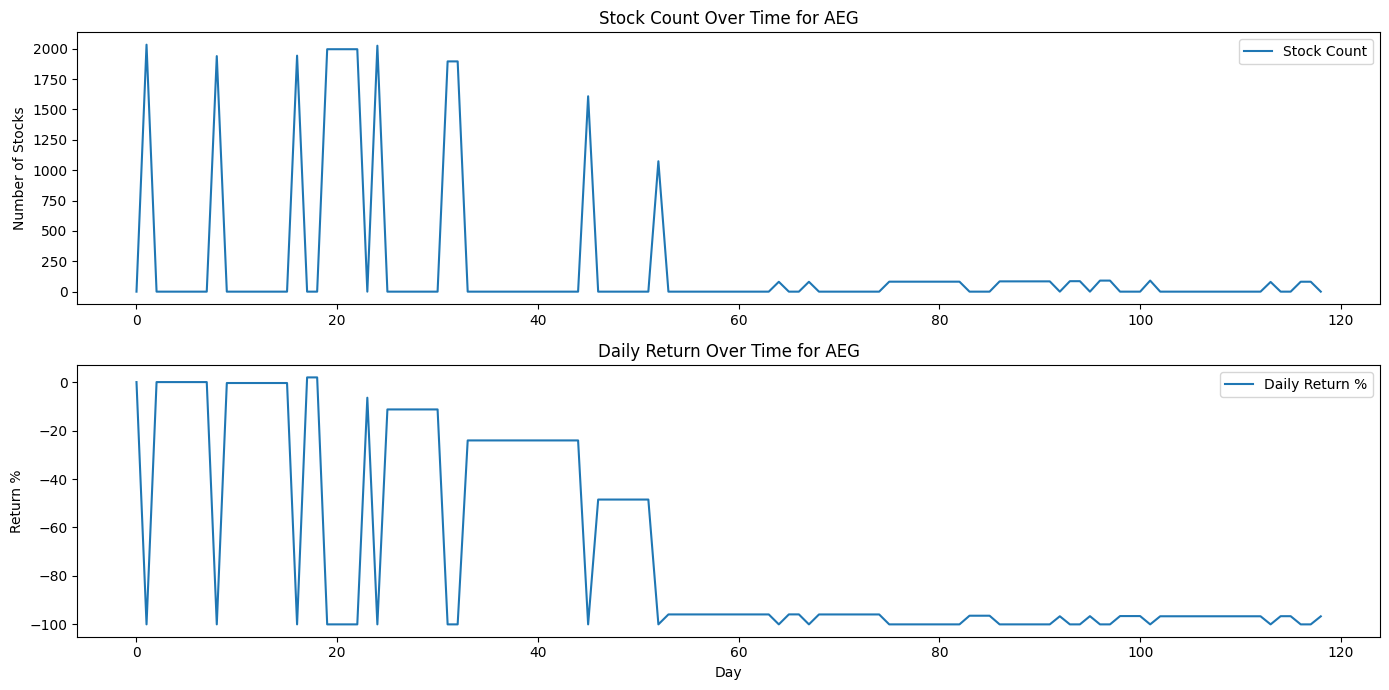

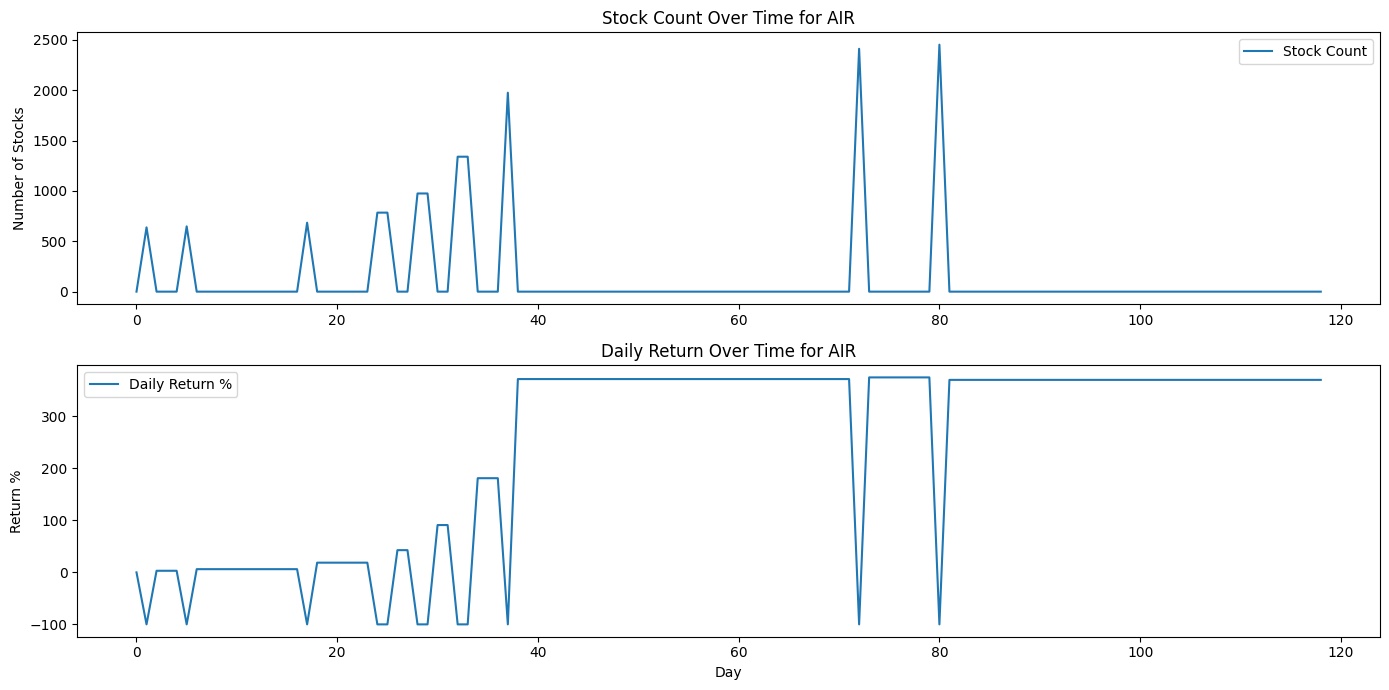

Total Return Rate: 6.33%, Remaining Extra Fund: 3159.8800402730267


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount('/content/drive')

def dynamic_stock(totalFund, y_predict, y_true, global_extra_fund):
    initial_total_fund = totalFund
    stockNum = 0
    has_stock = False
    stock_count = []  # Record of stock counts
    daily_returns = []  # Record of daily return percentages

    for today in range(len(y_predict) - 1):
        daily_return = (totalFund - initial_total_fund) / initial_total_fund * 100
        daily_returns.append(daily_return)
        stock_count.append(stockNum)

        if y_predict[today + 1] > y_true[today] and not has_stock:
            stockNum = totalFund / y_true[today]
            totalFund = 0
            has_stock = True
        elif y_predict[today + 1] < y_true[today] and has_stock:
            totalFund = stockNum * y_true[today]
            stockNum = 0
            has_stock = False

            if totalFund > initial_total_fund:
                increment = (totalFund - initial_total_fund)
                if global_extra_fund[0] >= increment:
                    global_extra_fund[0] -= increment
                    totalFund += increment
            else:
                decrement = (initial_total_fund - totalFund)
                if totalFund > decrement:
                    totalFund -= decrement
                    global_extra_fund[0] += decrement

    if has_stock:
        totalFund = stockNum * y_true[-1]

    return totalFund, stock_count, daily_returns

def calculate_total_returns(weights):
    companies = ['A', 'AA', 'ABC', 'ABCB', 'ACLS', 'ACNB', 'ADBE', 'ADP', 'AEG', 'AIR']
    total_fund = 600000
    total_initial_fund = total_fund + extraFund
    total_final_fund = 0

    total_weight = sum(weights.values())
    allocated_funds = {comp: (weight / total_weight) * total_fund for comp, weight in weights.items()}
    global_extra_fund = [extraFund]

    for company in companies:
        file_path = f'/content/drive/MyDrive/predictions/{company}_predictions.csv'
        df = pd.read_csv(file_path)
        y_predict = df['Predictions'].values
        y_true = df['Actual'].values
        allocated_fund = allocated_funds[company]
        final_fund, stock_counts, daily_returns = dynamic_stock(allocated_fund, y_predict, y_true, global_extra_fund)
        total_final_fund += final_fund

        # Plot stock counts and daily returns for each stock
        plt.figure(figsize=(14, 7))
        plt.subplot(2, 1, 1)
        plt.plot(stock_counts, label='Stock Count')
        plt.title(f'Stock Count Over Time for {company}')
        plt.ylabel('Number of Stocks')
        plt.legend()

        plt.subplot(2, 1, 2)
        plt.plot(daily_returns, label='Daily Return %')
        plt.title(f'Daily Return Over Time for {company}')
        plt.ylabel('Return %')
        plt.xlabel('Day')
        plt.legend()

        plt.tight_layout()
        plt.show()

    total_return_rate = (total_final_fund - total_initial_fund + global_extra_fund[0]) / total_initial_fund * 100
    print(f"Total Return Rate: {total_return_rate:.2f}%, Remaining Extra Fund: {global_extra_fund[0]}")

if __name__ == '__main__':
    weights = {
        'A': 3.687049859524796, 'AA': 2.219831145816969, 'ABC': 3.1676117011522384, 'ABCB': 4.337304887824643,
        'ACLS': 3.4969123897615013, 'ACNB': 23.896297604274523, 'ADBE': 47.189297012758736, 'ADP': 6.802566702378293,
        'AEG': 1.6770488395957608, 'AIR': 3.5260798569125256
    }
    calculate_total_returns(weights)


In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

def calculate_aape():
    companies = ['A', 'AA', 'ABC', 'ABCB', 'ACLS', 'ACNB', 'ADBE', 'ADP', 'AEG', 'AIR']
    total_aape = 0

    for company in companies:
        file_path = f'/content/drive/MyDrive/predictions/{company}_predictions.csv'
        df = pd.read_csv(file_path)
        y_predict = df['Predictions'].values
        y_true = df['Actual'].values

        # Calculate the absolute percentage error for each prediction
        aape = np.mean(np.abs((y_predict - y_true) / y_true)) * 100
        total_aape += aape
        print(f"AAPE for {company}: {aape:.2f}%")

    # Calculate the average AAPE across all companies
    average_aape = total_aape / len(companies)
    print(f"Average AAPE across all companies: {average_aape:.2f}%")

if __name__ == '__main__':
    calculate_aape()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
AAPE for A: 1.64%
AAPE for AA: 3.64%
AAPE for ABC: 2.32%
AAPE for ABCB: 1.90%
AAPE for ACLS: 2.60%
AAPE for ACNB: 1.69%
AAPE for ADBE: 2.51%
AAPE for ADP: 7.52%
AAPE for AEG: 1.75%
AAPE for AIR: 2.48%
Average AAPE across all companies: 2.81%
